In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
normal_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
gan_tb_dir_2000 = '/kaggle/input/tbgenerated/XRayNormalFake3'
gan_tb_dir_5000 = '/kaggle/input/tb-gan-generated-5000-epochs/tb+generated'

In [ ]:
def load_and_preprocess_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            img = imread(img_path, as_gray=True)
            img = resize(img, (128, 128))  # Reduced image size
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
normal_images, normal_labels = load_and_preprocess_images(normal_dir, 0)
gan_tb_images, gan_tb_labels = load_and_preprocess_images(gan_tb_dir_5000, 1)

In [ ]:
X = np.concatenate((normal_images, gan_tb_images), axis=0)
y = np.concatenate((normal_labels, gan_tb_labels), axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

In [ ]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [ ]:
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

In [ ]:
def create_cnn_model(input_shape):
    return keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_2'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
    ])

In [ ]:
def create_hybrid_model(input_shape, hog_input_shape):
    # CNN branch
    cnn_input = keras.layers.Input(shape=input_shape)
    cnn_model = create_cnn_model(input_shape)
    cnn_output = cnn_model(cnn_input)

    # HOG branch
    hog_input = keras.layers.Input(shape=(hog_input_shape,))
    hog_dense = keras.layers.Dense(32, activation='relu')(hog_input)

    # Combine CNN and HOG features
    combined = keras.layers.concatenate([cnn_output, hog_dense])

    # Output layer
    output = keras.layers.Dense(1, activation='sigmoid')(combined)

    # Create the hybrid model
    hybrid_model = keras.Model(inputs=[cnn_input, hog_input], outputs=output)

    return hybrid_model

In [ ]:
input_shape = (128, 128, 1)
hog_input_shape = X_train_hog.shape[1]
hybrid_model = create_hybrid_model(input_shape, hog_input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
hybrid_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
history = hybrid_model.fit(
    [X_train.reshape(-1, 128, 128, 1), X_train_hog],
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10


I0000 00:00:1729762584.256397     100 service.cc:145] XLA service 0x7b6de8004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729762584.256456     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729762584.256460     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 27/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7557 - loss: 0.4295

I0000 00:00:1729762588.612109     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9058 - loss: 0.1926 - val_accuracy: 0.9856 - val_loss: 0.0417
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9920 - loss: 0.0274 - val_accuracy: 0.9892 - val_loss: 0.0286
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9970 - loss: 0.0119 - val_accuracy: 0.9901 - val_loss: 0.0230
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0048 - val_accuracy: 0.9946 - val_loss: 0.0201
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9955 - val_loss: 0.0155
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9937 - val_loss: 0.0163
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9946 - val_loss: 0.0155
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9937 - va

In [ ]:
test_loss, test_accuracy = hybrid_model.evaluate([X_test.reshape(-1, 128, 128, 1), X_test_hog], y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9964


In [ ]:
predictions = hybrid_model.predict([X_test.reshape(-1, 128, 128, 1), X_test_hog])
predicted_labels = (predictions > 0.5).astype(int).flatten()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       732
           1       1.00      1.00      1.00       656

    accuracy                           1.00      1388
   macro avg       1.00      1.00      1.00      1388
weighted avg       1.00      1.00      1.00      1388



In [ ]:
import matplotlib.pyplot as plt

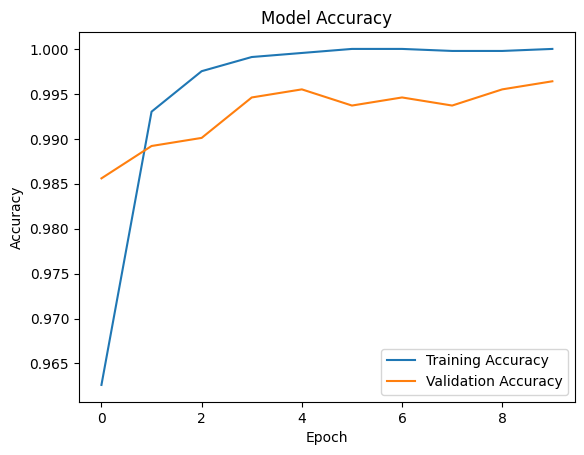

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

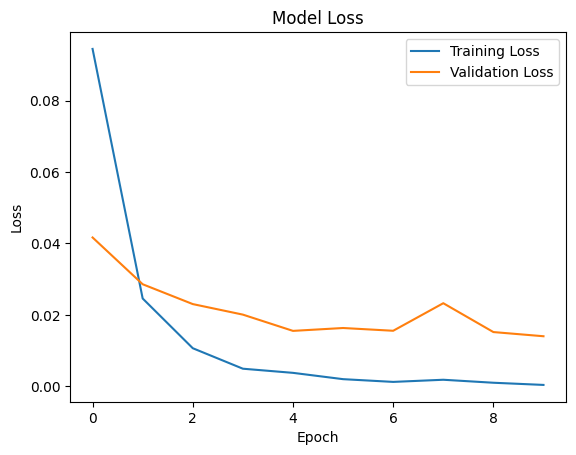

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

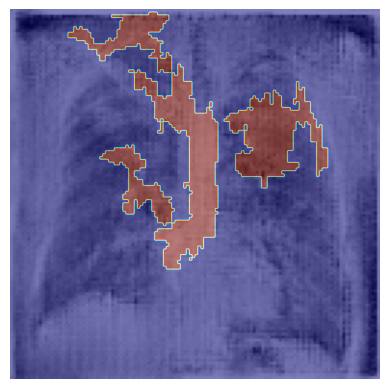

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb
import tensorflow as tf
from tensorflow import keras

# Function to get the CNN submodel from the hybrid model
def get_cnn_submodel(hybrid_model):
    cnn_model = hybrid_model.get_layer('sequential')  # The CNN model is the Sequential part
    cnn_input = cnn_model.input
    cnn_output = cnn_model.output  # Output from the CNN part
    cnn_submodel = keras.Model(inputs=cnn_input, outputs=cnn_output)
    return cnn_submodel

# LIME function that explains grayscale images (single-channel)
def explain_image_with_lime(model, img):
    explainer = lime_image.LimeImageExplainer()

    # Explain the predictions for the input grayscale image, using felzenszwalb segmentation
    explanation = explainer.explain_instance(
        img[0],  # The input image (single-channel grayscale)
        model.predict,  # Function that predicts using the CNN submodel
        top_labels=2,  # We want the explanation for the top 2 predicted labels
        hide_color=0,  # Superpixels will be zeroed out when perturbed
        num_samples=1000,  # Number of perturbations
        segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)  # Use felzenszwalb instead of quickshift
    )

    return explanation

# Load an example grayscale image and preprocess it
img_path = '/kaggle/input/tb-gan-generated-5000-epochs/tb+generated/XRay_generated 0013.png'  # Replace with your own image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Get the CNN submodel from the hybrid model
cnn_submodel = get_cnn_submodel(hybrid_model)

# Explain the image using LIME on the CNN submodel
explanation = explain_image_with_lime(cnn_submodel, img_array)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

# Reshape the mask to match the original grayscale image
mask = np.reshape(mask, (128, 128))  # Adjust according to your image size

# Display the image with the LIME heatmap
plt.imshow(img_array[0, :, :, 0], cmap='gray')  # Original grayscale image
plt.imshow(mask, cmap='jet', alpha=0.5)  # Heatmap overlay
plt.axis('off')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

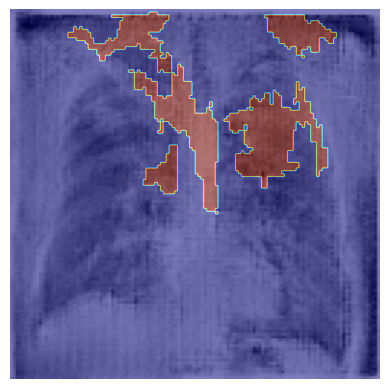

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb
import tensorflow as tf
from tensorflow import keras

# Function to get the CNN submodel from the hybrid model
def get_cnn_submodel(hybrid_model):
    cnn_model = hybrid_model.get_layer('sequential')  # The CNN model is the Sequential part
    cnn_input = cnn_model.input
    cnn_output = cnn_model.output  # Output from the CNN part
    cnn_submodel = keras.Model(inputs=cnn_input, outputs=cnn_output)
    return cnn_submodel

# LIME function that explains grayscale images (single-channel)
def explain_image_with_lime(model, img):
    explainer = lime_image.LimeImageExplainer()

    # Explain the predictions for the input grayscale image, using felzenszwalb segmentation
    explanation = explainer.explain_instance(
        img[0],  # The input image (single-channel grayscale)
        model.predict,  # Function that predicts using the CNN submodel
        top_labels=2,  # We want the explanation for the top 2 predicted labels
        hide_color=0,  # Superpixels will be zeroed out when perturbed
        num_samples=1000,  # Number of perturbations
        segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)  # Use felzenszwalb instead of quickshift
    )

    return explanation

# Load an example grayscale image and preprocess it
img_path = '/kaggle/input/tb-gan-generated-5000-epochs/tb+generated/XRay_generated 0013.png'  # Replace with your own image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Get the CNN submodel from the hybrid model
cnn_submodel = get_cnn_submodel(hybrid_model)

# Explain the image using LIME on the CNN submodel
explanation = explain_image_with_lime(cnn_submodel, img_array)

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

# Reshape the mask to match the original grayscale image
mask = np.reshape(mask, (128, 128))  # Adjust according to your image size

# Display the image with the LIME explanation overlaid with a 'jet' heatmap
plt.imshow(img_array[0, :, :, 0], cmap='gray')  # Original grayscale image
plt.imshow(mask, cmap='jet', alpha=0.5)  # Heatmap overlay with 'jet' colormap
plt.axis('off')
plt.show()
